## Industrial Machines Malfunction Detection using Deep Learning
### Valves, Slide-rails and Industrial Fans

### Training a CNN on MFCC features generated from equipment sound files
- Rajesh Siraskar | 25-May-2021
----
- V.3.0: CNN for audio category classification
- V.3.1 
---- 

- Load data
- Create train/validation/test sets (unseen)
- Build CNN network architecture
- Compile network
- Train network
- Evaluate
- Make predictions on a sample

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

from utilities import *
%matplotlib inline

In [3]:
JSON_FILE = "audio_files/machine_features.json"
NUMBER_OF_CLASSES = 6 # Machine normal/abnormal
TRAIN_EPOCHS = 150

### 1. Create train/validation/test sets (unseen)
--------------------------------------------------------

#### Note: CNN expects a 3-D array.
    - Our data was saved with the following parameters
    - num_mfcc=13; num_segments=10; num_mfcc_vectors_per_segment: 130
    - X.data.shape:  (80, 130, 13)
    - y.data.shape:  (80,)
    
    - X.data.shape: dim-1: No of samples = 4 classes * 2 .wav files per genre * 10 segments = 80, 
    -               dim-2: time-bins = 130, 
    -               dim-3: mfcc-features = 13)

### For CNN we need to add an additional channel: 
    - Loaded X is (80, 130, 1)
    - For CNN, X needs to be (130, 13, 1)
    - The 3rd dim is the CHANNEL so will be 1
    - So X becomes actually a 4D arraay with the added channel dim

In [9]:
def prepare_datasets(test_size=0.25, validation_size=0.2):
    # load data
    X, y = load_data(JSON_FILE)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # create train/validation set
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                    test_size=validation_size)
    
    # CNN expects a 3-D array
    # -----------------------
    # Our data was saved with the following parameters
    #    num_mfcc=13; num_segments=10; num_mfcc_vectors_per_segment: 130
    # X.data.shape: dim-1: No of samples = 4 classes * 2 .wav files per genre * 10 segments = 80, 
    #               dim-2: time-bins = 130, 
    #               dim-3: mfcc-features = 13)
    # y.data.shape:  (80,)
    #
    #
    # For CNN we need to add an additional channel: 
    # - Loaded X is (80, 130, 1)
    # - For CNN, X needs to be (130, 13, 1)
    # - The 3rd dim is the CHANNEL so will be 1
    # - So X becomes actually a 4D arraay with the added channel dim
    
    # Create the 3-D array for X_train, but first add newaxis for channel
    X_train = X_train [..., np.newaxis]           # 4D array = [num_sample, 130, 13, 1]
    X_validation = X_validation [..., np.newaxis] # -- "" --
    X_test = X_test [..., np.newaxis]             # -- "" --
    
    # Return the 4-D data
    return  X_train, X_validation, X_test, y_train, y_validation, y_test

### 2. Build the CNN network

In [42]:
def build_model(input_shape):
    
    # Ceate model
    model = keras.Sequential()
    # 1st conv. layer (along with max-pooling,normalize output - which speeds up training)
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                                  input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())              
    
    # 2nd. conv. layer - same as above. Note input shape remains same
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                                  input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())                      
    
    # 3rd. conv. layer - same as above but reduce filter sizes (both kernel and pooling)
    # Again, note, input shape remains same
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization()) 
    
    # Flatten the output and feed to a dense layer, also add dropout to reduce over-fitting
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # Final output layer with softmax) for classification
    # Neurons = number of classes i.e. genres = NUMBER_OF_CLASSES
    model.add(keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))
    
    return model

### Utility functions: 
1. Plot accuracy/loss curves
2. Load JSON data file and return genre names

### Main function
1. Create train/validation/test sets (unseen)
2. Build the CNN network
3. Compile the network
4. Train the model
5. Evaluate the model on unseen test set
6. Predict on a sample

In [10]:
## 1. Create train/validation/test sets (unseen)
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(test_size=0.25,
                                                                                validation_size=0.20)

1. num_mfcc: 13
2. num_segments: 2
3. SAMPLES_PER_TRACK: 220500
4. num_mfcc_vectors_per_segment 216
5. NUM_CATEGORIES: 6
6. num_of_audio_files_per_category = 100
7. num_of_records = num_of_categories*num_of_audio_files_per_category*NUM_SEGMENTS = 1200
X.data.shape: (1200, 216, 13) (no_records, num_mfcc_vectors_per_segment, num_mfcc)
y.data.shape: (1200,) (no_records, )

In [44]:
X_train.shape

(720, 216, 13, 1)

In [45]:
## 2. Build the CNN network
#  X_train is a 4-D array. For input shape, take the 3-dims from dimension 2 onwards. 
#  The 1st dim was num_samples and is not considered as it will be part of training samples
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

## 3. Compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 4. Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_validation, y_validation), 
                    batch_size=32, 
                    epochs=TRAIN_EPOCHS) # 30 epochs accuracy=0.70; 400 epochs=0.95

## 5. Evaluate the model on unseen test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1) 
print("\n\n - Accuracy on un-seen test set: {0:.3f}".format(test_accuracy))

Train on 720 samples, validate on 180 samples
Epoch 1/150
720/720 [==============================] - 2s 3ms/sample - loss: 2.3912 - acc: 0.2639 - val_loss: 3.9370 - val_acc: 0.1778
Epoch 2/150
720/720 [==============================] - 2s 2ms/sample - loss: 1.4083 - acc: 0.5083 - val_loss: 2.1626 - val_acc: 0.2056
Epoch 3/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.9366 - acc: 0.6569 - val_loss: 1.5096 - val_acc: 0.2889
Epoch 4/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.7014 - acc: 0.7472 - val_loss: 1.2096 - val_acc: 0.4500- loss: 0.7295 - a
Epoch 5/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.5574 - acc: 0.7986 - val_loss: 1.0534 - val_acc: 0.4944
Epoch 6/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.4863 - acc: 0.8083 - val_loss: 0.9159 - val_acc: 0.5889
Epoch 7/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.4229 - acc: 0.8347 - val_loss: 0.8064 - val_acc

Epoch 120/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.0103 - acc: 0.9986 - val_loss: 0.1770 - val_acc: 0.9333
Epoch 121/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.0090 - acc: 0.9986 - val_loss: 0.1662 - val_acc: 0.9389
Epoch 122/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.0113 - acc: 0.9986 - val_loss: 0.1822 - val_acc: 0.9389
Epoch 123/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.0168 - acc: 0.9958 - val_loss: 0.2836 - val_acc: 0.9222
Epoch 124/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.0149 - acc: 0.9958 - val_loss: 0.2401 - val_acc: 0.9222
Epoch 125/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.0106 - acc: 1.0000 - val_loss: 0.2213 - val_acc: 0.9167
Epoch 126/150
720/720 [==============================] - 2s 2ms/sample - loss: 0.0162 - acc: 0.9972 - val_loss: 0.2170 - val_acc: 0.9278
Epoch 127/150
720/720 [==================

In [46]:
# Save model
model.save("CNN_model_V3")

In [47]:
## 5. Evaluate the model on unseen test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=0) 
print("- Accuracy on un-seen test set: {0:.3f}".format(test_accuracy))

- Accuracy on un-seen test set: 0.970


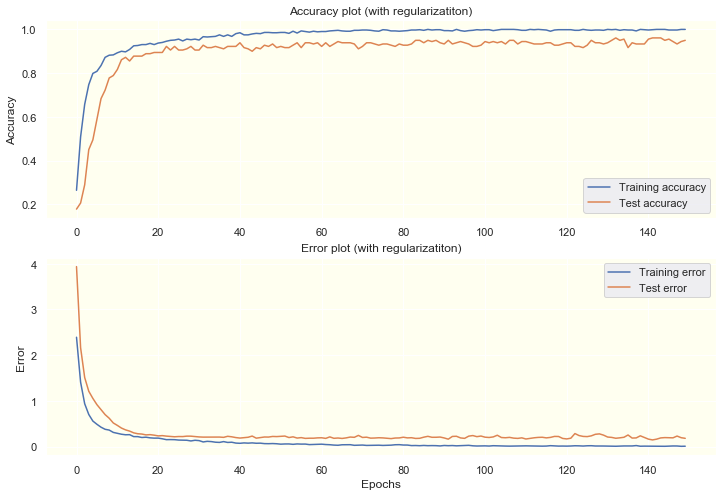

In [48]:
## 7. Plot training curves - NO regularization
plot_history(history, regularization_flag=True)

In [52]:
# First get the labels from the numerical indices, so that predicted vales are readable
signal_label_mappings = map_signal_labels(JSON_FILE)

y_actual = []
y_predicted = []

## 6. Predict
for n in range(40):
    sample = random.randint(0,200) # Total 20 samples, so select any sample 1-20
    X = X_test[sample] 
    y = y_test[sample]
    
    (actual_machine_label, predicted_machine_label) = predict(model, X, y, signal_label_mappings)
    y_actual.append(actual_machine_label)
    y_predicted.append(predicted_machine_label)

                         industrial_fan_abnormal  industrial_fan_normal  \
industrial_fan_abnormal                       10                      0   
industrial_fan_normal                          0                      8   
slide_rail_abnormal                            0                      0   
slide_rail_normal                              0                      0   
valve_abnormal                                 0                      0   
valve_normal                                   0                      0   

                         slide_rail_abnormal  slide_rail_normal  \
industrial_fan_abnormal                    0                  0   
industrial_fan_normal                      0                  0   
slide_rail_abnormal                        5                  0   
slide_rail_normal                          0                  3   
valve_abnormal                             0                  0   
valve_normal                               0                  2   

    

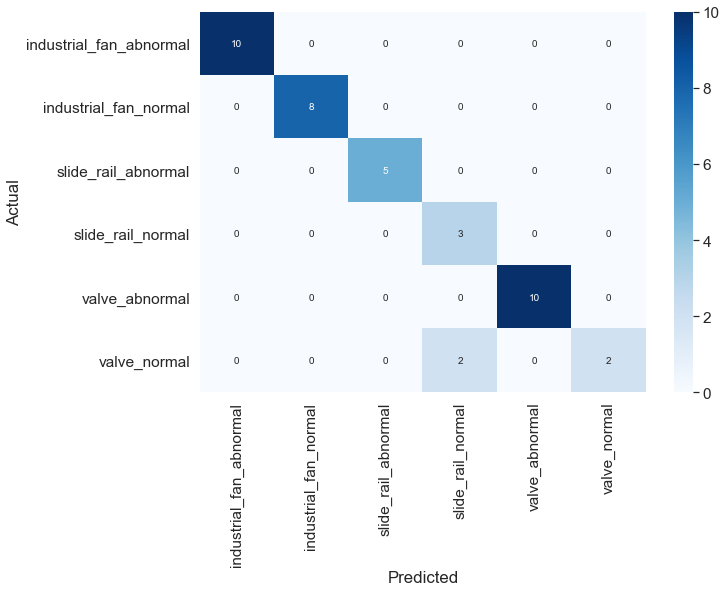

In [53]:
plot_confusion_matrix(y_actual, y_predicted)

In [5]:
reconstructed_model = keras.models.load_model("CNN_model_V3")

In [11]:
# First get the labels from the numerical indices, so that predicted vales are readable
signal_label_mappings = map_signal_labels(JSON_FILE)

y_actual = []
y_predicted = []

## 6. Predict
for n in range(40):
    sample = random.randint(0, 10) # Total 20 samples, so select any sample 1-20
    X = X_test[sample] 
    y = y_test[sample]
    
    (actual_machine_label, predicted_machine_label) = predict(reconstructed_model, X, y, signal_label_mappings)
    y_actual.append(actual_machine_label)
    y_predicted.append(predicted_machine_label)
    
plot_confusion_matrix(y_actual, y_predicted)

NameError: name 'signal_label_mappings' is not defined